In [1]:
using DelimitedFiles, FileIO
using Plots, Rsvg, LaTeXStrings
using Chemfiles, JUMD, NamedArrays
using LinearAlgebra, Statistics, Printf

casa = string("/home/pbarletta/labo/20/bisana/run/egfr")
rtdos = "/home/pbarletta/labo/20/bisana/rtdos_log"

"/home/pbarletta/labo/20/bisana/rtdos_log"

In [2]:
function write_mtx(output_mtx, file::AbstractString)
    nrows = size(output_mtx)[1]
    ncols = size(output_mtx)[2]

    open(file, "w") do f
        for i in 1:nrows
            for j in 1:ncols
                @printf f "%10.6F" output_mtx[i, j]
            end
            @printf f "%s" "\n"
        end
    end
end

function write_vtr(output_vtr, file::AbstractString)
    ncols = length(output_vtr)

    open(file, "w") do f
        for i in 1:ncols
            @printf f "%10.6F" output_vtr[i]
            @printf f "%s" "\n"
        end        
    end
end

write_vtr (generic function with 1 method)

## VGV en cartesianas

In [4]:
vgv_1m14 = convert(Array{Float64, 1}, readdlm(joinpath(casa, "flx", "5_vgv_1m14"))[:, 1])
vgv_1xkk = convert(Array{Float64, 1}, readdlm(joinpath(casa, "flx", "5_vgv_1xkk"))[:, 1])

vgv_1m14 = vgv_1m14 ./ norm(vgv_1m14)
vgv_1xkk = vgv_1xkk ./ norm(vgv_1xkk)

modes_1m14 = readdlm(joinpath(casa, "eigenvectors", "1m14_modos"))
modes_1xkk = readdlm(joinpath(casa, "eigenvectors", "1xkk_modos"))

xyz_vgv_1m14 = modes_1m14 * vgv_1m14
xyz_vgv_1xkk = modes_1xkk * vgv_1xkk

write_vtr(xyz_vgv_1m14, joinpath(casa, "porc", "xyz_vgv_1m14"))
write_vtr(xyz_vgv_1xkk, joinpath(casa, "porc", "xyz_vgv_1xkk"))

## Volúmenes

In [13]:
vol_1m14 = convert(Float64, readdlm(joinpath(casa, "cavidad", string("vol_1m14")))[1, 2])
vol_1xkk = convert(Float64, readdlm(joinpath(casa, "cavidad", string("vol_1xkk")))[1, 2])

flx_1m14 = convert(Float64, readdlm(joinpath(casa, "flx", string("flx_1m14_5")))[1, 2])
flx_1xkk = convert(Float64, readdlm(joinpath(casa, "flx", string("flx_1xkk_5")))[1, 2])

NamedArray([ vol_1m14 vol_1xkk ;
     flx_1m14 flx_1xkk ],
    ([ "Volume" ; "Rigidity"], ["1M14" ; "1XKK" ]))

2×2 Named Array{Float64,2}
   A ╲ B │    1M14     1XKK
─────────┼─────────────────
Volume   │  1350.2  1180.38
Rigidity │ 4.93898  6.00232

### Flexibilidad con modos de Calpha

In [5]:
coff = 15
global flx_ecf_ca = Array{Float64, 1}(undef, n_rmn)
global flx_edf_ca = Array{Float64, 1}(undef, n_rmn)

for i in 1:n_rmn
    flx_ecf_ca[i] = convert(Float64, readdlm(joinpath(
        casa_ca, string(coff, "_cutoff_1f96"), "flx", string(i, "_flx_ecf_5")))[1, 2]) 
    flx_edf_ca[i] = convert(Float64, readdlm(joinpath(
        casa_ca, string(coff, "_cutoff_1f96"), "flx", string(i, "_flx_edf_5")))[1, 2]) 
end

sym_flx_ecf_ca = Symbol("flx_ecf_ca_", coff)
sym_flx_edf_ca = Symbol("flx_edf_ca_", coff)
eval(:($sym_flx_ecf_ca = flx_ecf_ca))
eval(:($sym_flx_edf_ca = flx_edf_ca));

## Resultados

In [6]:
vol = [ vol_ecf ; vol_edf]
flx_ca_15 = [ flx_ecf_ca_15 ; flx_edf_ca_15]

NamedArray([ mean(vol) std(vol) std(vol) / mean(vol) ;
     mean(flx_ca_15) std(flx_ca_15) std(flx_ca_15) / mean(flx_ca_15) ],
    ([ "Volume" ; "CA"], ["μ" ; "std" ; "std / μ"]))

2×3 Named Array{Float64,2}
 A ╲ B │         μ        std    std / μ
───────┼────────────────────────────────
Volume │   273.057    41.4703   0.151874
CA     │ 0.0358511  0.0045123   0.125862

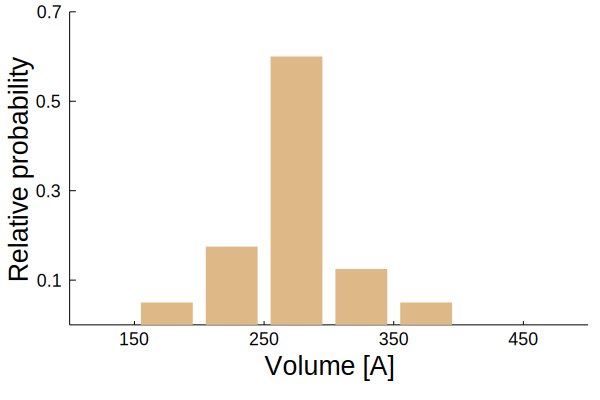

In [17]:
st = 50
min_vol = 100
max_vol = 500
bin_vol = collect(min_vol:st:max_vol)
wgh_vol = fill(1.0, length(vol))

# Histograma ponderado
Wbins_vol_acb, Whis_vol_acb = JUMD.weightedHist(vol, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_acb, Whis_vol_acb,
    xlims = (min_vol, max_vol),
    xticks = min_vol+st:st*2:max_vol-st,
    yticks = .1:.2:.7, ylims = (0, .7),
    linecolor = false, fillcolor = Colors.colorant"BurlyWood",
    grid = false, legend = false,
    guidefont = font(18, "Arial"), tickfont = font(12, "Arial"),
    yaxis = "Relative probability", xaxis = "Volume [A]
    ")

In [18]:
savefig(plt_his_vol, joinpath(rtdos, string("vol_1f96", ".svg")))

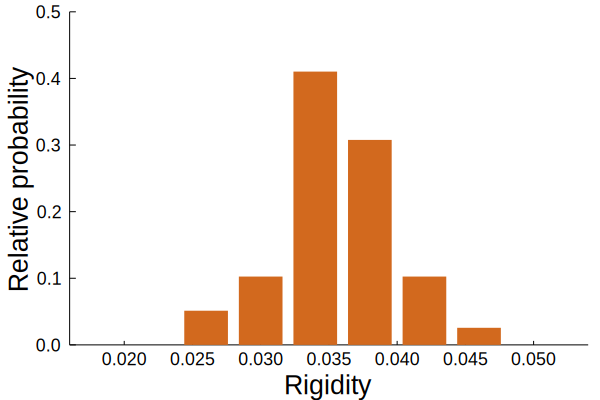

In [19]:
st = 0.004
min_rig = 0.02
max_rig = 0.05
bin_rig = collect(min_rig:st:max_rig)
wgh_rig = fill(1.0, length(flx_ca_15))

Wbins_rig_acb, Whis_rig_acb = JUMD.weightedHist(flx_ca_15, bin_rig, wgh_rig, true, false);

plt_his_rig = bar(Wbins_rig_acb, Whis_rig_acb,
    xlims = (min_rig-st, max_rig+st), ylims = (0, .5),
    xticks = min_rig:5E-3:max_rig,
    name = "1F96",
    legend = false,
    linecolor = false, fillcolor = Colors.colorant"Chocolate",
    grid = false,
    guidefont = font(18, "Arial"), tickfont = font(12, "Arial"),
    yaxis = "Relative probability", xaxis = "Rigidity")

In [20]:
savefig(plt_his_rig, joinpath(rtdos, string("rig_1f96_carmn", ".svg")))